In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import Levenshtein
from pathlib import Path
import pickle as pk
import numpy as np
import pickle as pk

from src.analysis.fraudulous import filter_out, detect_honey_frauders, detect_repeat_frauders,study_outsiders
from src.constants import HONEYPOTS, EMOJI_DATASET_DIR, HONEYPOTS, EM_VOC_COUNT
from src.analysis.postprocessing import (scrap_form_results, get_emojis_voc_counts, write_emojis_voc_counts,
                                         display_whole_dir, generate_production_format, build_worker_info_table,
                                        plot_hist_nmb_anot_per_emoji)
from src.analysis.spelling import WordSuggester
from src.analysis.postprocessing import plot_nmb_form_per_worker
import matplotlib.pyplot as plt

In [6]:
form_dfs = scrap_form_results(EMOJI_DATASET_DIR)
df = generate_production_format(form_dfs)

100%|██████████| 133/133 [00:03<00:00, 37.17it/s]


In [17]:
a = [i for i in form_dfs if "⛔" in i.columns][0]
a

,Timestamp,WorkerID,🦚,🧵,🐣,📣,🍢,🍍,👨‍⚕️,🔃,⛔,🎠,🦽,FormId,AnswerDurationInSeconds,Age,Gender,Mothertongue
0,17/12/2020 14:12:28,A4VUQ6627RJX8,peacock,thread,chick,speaker,shapes,pineapple,doctor,reload,minimize,toy,cycle,56,279.0,36.0,Male,english
1,17/12/2020 14:12:48,A13OMD8QDV0YON,peacock,thread,chich,blowhorn,smore,pineapple,doctor,uturn,stop,ferrygoround,wheelchair,56,168.0,30.0,Male,english
2,17/12/2020 14:16:05,A3RIX2H2NYLNC4,peacock,thread,chick,loudspeaker,kabob,pineapple,doctor,repeat,closed,horse,wheelchair,56,135.0,29.0,Female,english
3,17/12/2020 14:16:14,A1TW2BZRRS874Z,peacock,wire,chick,loud,kabob,pinapple,doctor,turnaround,stop,carousel,wheelchair,56,517.0,37.0,Male,english
4,17/12/2020 14:17:46,A82WUWI7H3MZWA,peacock,petroltack,bird,speacker,chocolate,fruit,man,arrow,stop,horse,cycle,56,NaN,35.0,Female,english
5,17/12/2020 14:18:00,A3CI73EFDLS3OF,peacock,yarn,chick,megaphone,skewer,pineapple,doctor,roundabout,no,merrygoround,wheelchair,56,505.0,30.0,Female,english
6,17/12/2020 14:18:50,A2D2JX8R0QU9G4,peacock,winding,chick,amplifier,barbeque,pineapple,doctor,return,expand,horsedoll,wheelchair,56,674.0,33.0,Female,english
7,17/12/2020 14:18:51,A1I72NHC21347A,peacock,address,chicks,loud,direct,pineapple,doctor,around,less,carousel,handicapped,56,685.0,56.0,Female,english
8,17/12/2020 14:19:18,A30UE6DWFNUCWX,peacock,thread,chick,amplify,kabob,pineapple,doctor,turn,restricted,carousel,wheelchair,56,710.0,32.0,Female,english
9,17/12/2020 14:20:13,AXPZAP62ZYWP8,peacock,yarn,chick,megaphone,kabbobs,pinapple,doctor,reverse,stop,caracel,wheelchair,56,745.0,25.0,Male,english


In [7]:
df[df['emoji'] == '🌏']

,WorkerID,FormId,Duration,emoji_index,emoji,word
28471,A14OPFM8OFA4WF,14,261.0,216,🌏,earth
28611,A1ZH5VWU96MECI,14,401.0,216,🌏,earth
28461,AT6LDQNLKTUSE,14,553.0,216,🌏,earth
28491,A2KX8SX5M47GPX,14,95.0,216,🌏,globe
28501,A3J2T92V25NJ83,14,61.0,216,🌏,earth
28521,A22F7GLMAVXBBW,14,96.0,216,🌏,world
28511,A20VNT5IHVO401,14,421.0,216,🌏,world
28591,A1TGZ063G5UKEC,14,489.0,216,🌏,world
28531,AOMFEAWQHU3D8,14,334.0,216,🌏,world
28581,A1CM4AU052HWDO,14,79.0,216,🌏,earth


In [3]:
# create the worker infos table
worker_infos = build_worker_info_table(input_directory=EMOJI_DATASET_DIR)

# Postprocessing

<div class="alert alert-success">
Postprocessing of data gathered from mturk/gform
</div>

## Frauder Detection

In [5]:
# List of all df in child directories of dataset dir
form_dfs = scrap_form_results(EMOJI_DATASET_DIR)

N = sum([df.shape[0] for df in form_dfs])
print(f"Initial data shape: {N} rows")

100%|██████████| 133/133 [00:02<00:00, 52.76it/s]

Initial data shape: 4042 rows


#### Repeat frauders

In [6]:
n_frauders, form_dfs = filter_out(
    form_dfs, detect_repeat_frauders, 0.8, verbose=True, display_=False)

Discarded 1 rows


#### Honeypots frauders

In [7]:
honeypots = HONEYPOTS
dist_lshtein = 2

# Uncomment the cell to check for refused honeypots words
# study_outsiders(form_dfs,HONEYPOTS,dist_lshtein)

n_honey, form_dfs = filter_out(
    form_dfs, detect_honey_frauders, HONEYPOTS, dist_lshtein=dist_lshtein, verbose=True)

Discarded 433 rows


## Visualizing the vocabulary 

<div class="alert alert-success">
We compute the value counts of every word for each emoji and save it to a file.
</div>

In [8]:
em2vocab = get_emojis_voc_counts(EMOJI_DATASET_DIR)
write_emojis_voc_counts(em2vocab, EM_VOC_COUNT)

## Generating final format

In [10]:
tot_df = generate_production_format(form_dfs)

100%|██████████| 133/133 [00:03<00:00, 35.47it/s]


### Correcting misspelled words

In [95]:
sugg = WordSuggester()
sugg.correct_prod_df(tot_df,debug=True)

Initializing the vocabulary set..
Initializing BERT pipeline..


 10%|█         | 3/30 [00:00<00:01, 13.91it/s]

Modified:  astrik --> astrid (corrected)
Modified:  asterik --> asterisk (cross_suggested)
Modified:  coppyright --> copyright (cross_suggested)
Modified:  cee --> cen (corrected)


100%|██████████| 30/30 [00:00<00:00, 66.13it/s]

Modified:  circler --> circle r (disassembled2)
Modified:  capitalr --> capital r (disassembled2)
Modified:  excalmation --> exclamation (cross_suggested)
Modified:  exclamationquestion --> exclamation question (disassembled1)
Modified:  leftright --> left right (disassembled1)
Modified:  leftorright --> left or right (disassembled1)
Modified:  whichway --> which way (disassembled1)
Modified:  upanddown --> up and down (disassembled1)
Modified:  upleftarrow --> up left arrow (disassembled1)
Modified:  risingsign --> rising sign (disassembled1)
Modified:  thatway --> that way (disassembled1)
Modified:  arrowbottomleftcorner --> arrow bottom left corner (disassembled1)
Modified:  sandglass --> sand glass (disassembled1)
Modified:  playandstop --> play and stop (disassembled1)
Nof found:  fastfoward
Modified:  backtotop --> back to top (disassembled1)
Modified:  uparrow --> up arrow (disassembled2)
Modified:  foward --> forward (cross_suggested)
Modified:  downvote --> down vote (disassem

## Plotting Statistics

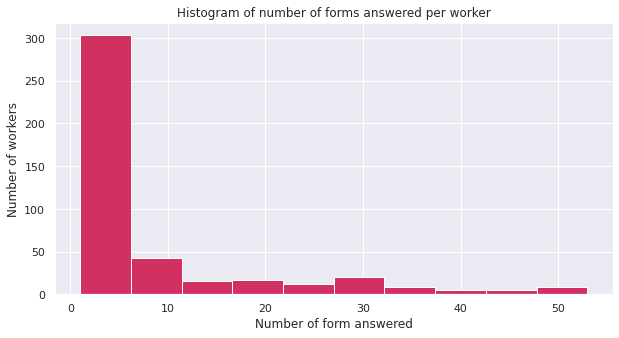

In [71]:
plot_nmb_form_per_worker(tot_df)

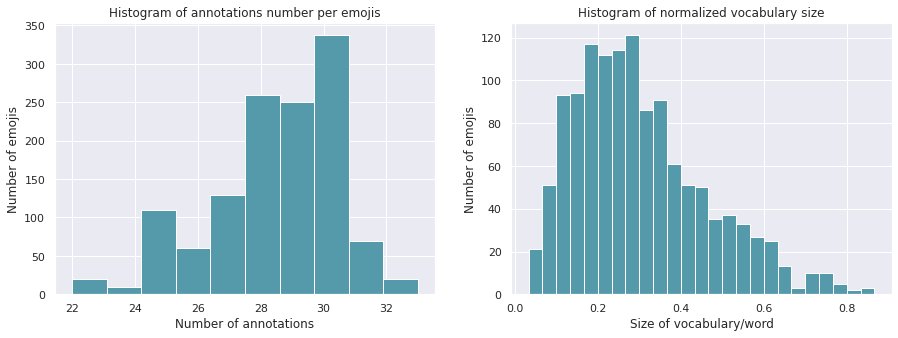

In [57]:
plot_hist_nmb_anot_per_emoji(tot_df)